## Explore sample intersection between TCGA data types

As we add more data types to our classification experiments, we've been filtering to only the set of samples that have data for each included data type. We want to know more about how many samples and which/how many cancer types are affected by this filtering, since it could influence the results in subtle ways.

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from venn import venn, pseudovenn, generate_petal_labels
import upsetplot as up

import mpmp.config as cfg
import mpmp.utilities.data_utilities as du

In [2]:
# if True, save figures to ./images directory
SAVE_FIGS = True

In [3]:
# map data types to readable names
data_map = {
    'expression': 'expression',
    'me_27k': '27k',
    'me_450k': '450k',
    'rppa': 'RPPA',
    'mirna': 'microRNA',
    'mut_sigs': 'mut. sigs',
}

# get sample list for each -omics data type
sample_lists = {}
for training_data, sample_info_file in cfg.sample_infos.items():
    samples = pd.read_csv(sample_info_file, sep='\t', index_col=0).index
    try:
        sample_lists[data_map[training_data]] = set(samples)
    except KeyError: 
        # bias-corrected results, ignore them here
        import sys
        print(training_data, file=sys.stderr)
        continue

mutation
me_27k_bmiq


In [4]:
# add mutation data to sample list
pancan_data = du.load_pancancer_data()
(sample_freeze_df,
 mutation_df,
 copy_loss_df,
 copy_gain_df,
 mut_burden_df) = pancan_data

print(sample_freeze_df.shape)
print(mutation_df.shape)
print(copy_loss_df.shape)
print(copy_gain_df.shape)
print(mut_burden_df.shape)

(9074, 4)
(9074, 20938)
(9074, 25128)
(9074, 25128)
(9074, 1)


In [5]:
# all these dfs contain the same samples, so just use one of the indexes
sample_lists['mutation'] = set(mutation_df.index)

In [6]:
# counts per data type
print('\n'.join(['{}\t{}'.format(n, len(v)) for n, v in sample_lists.items()]))

expression	11060
27k	11975
450k	9629
RPPA	7790
microRNA	10818
mut. sigs	9493
mutation	9074


### Count overlap between gene expression and mutation data

We'll start by just counting the number of samples that have data for gene expression and mutations, corresponding to the first figure panel.

In [7]:
def series_from_samples(samples, labels):
    # use pyvenn to generate overlaps/labels from sample IDs
    venn_labels = generate_petal_labels(samples)
    # generate format upset plot package expects
    df_ix = [[(i == '1') for i in list(b)] + [int(v)] for b, v in venn_labels.items()]
    # generate dataframe from list
    rename_map = {ix: labels[ix] for ix in range(len(labels))}
    index_names = list(rename_map.values())
    rename_map[len(labels)] = 'id'
    df = (pd.DataFrame(df_ix)
        .rename(columns=rename_map)
        .set_index(index_names)
    )
    # and return as series
    return df['id']

Text(0.5, 1.0, 'TCGA sample intersections, gene expression data')

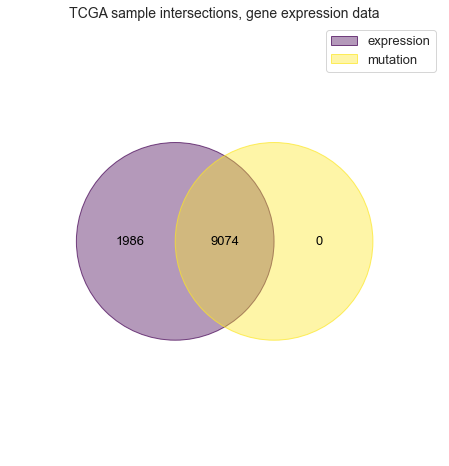

In [8]:
sns.set({'figure.figsize': (8, 10)})
sns.set_style('white')

# get only sample lists from gene expression and mutation
labels = ['expression', 'mutation']
label_map = {l: sample_lists[l] for l in labels}

venn(label_map)
plt.title('TCGA sample intersections, gene expression data', size=14)

### Count overlap between gene expression, methylation, and mutation datasets

In [9]:
sns.set_style('white')
labels = ['expression', 'mutation', '27k', '450k']
samples = [sample_lists[l] for l in labels]

upset_series = series_from_samples(samples, labels)
upset_series[upset_series != 0].sort_values().head(20)

expression  mutation  27k    450k 
False       False     False  True        2
True        False     False  True        4
            True      False  False       5
                             True       16
            False     True   False     416
                      False  False     452
False       False     True   True      512
                             False     880
True        True      True   False    1072
            False     True   True     1114
            True      True   True     7981
Name: id, dtype: int64

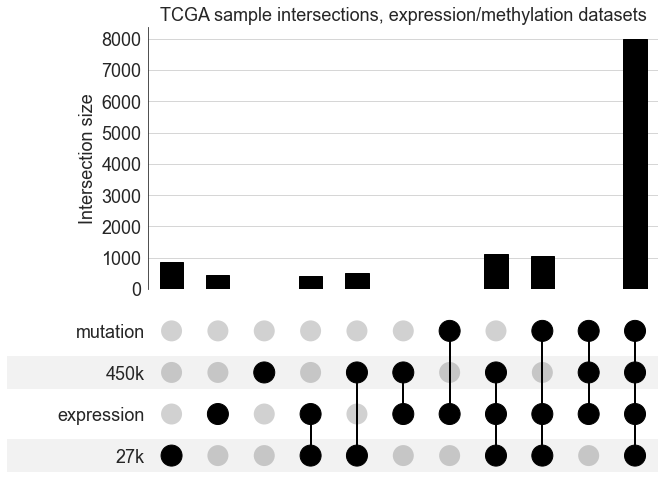

In [10]:
subplots = up.plot(upset_series[upset_series != 0], element_size=60,
                   totals_plot_elements=1)
plt.title('TCGA sample intersections, expression/methylation datasets', size=18)
plt.ylabel('Intersection size', size=18)
plt.yticks(fontsize=18)
subplots['matrix'].set_yticklabels(labels=subplots['matrix'].get_yticklabels(), fontsize=18)
plt.gcf().delaxes(subplots['totals'])

# we can clean up whitespace below in figure assembly script
if SAVE_FIGS:
    images_dir = Path(cfg.images_dirs['data'])
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'expression_me_overlap_upset.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'expression_me_overlap_upset.png',
                dpi=300, bbox_inches='tight')

### Count overlap between all datasets

In [11]:
sns.set_style('white')
labels = ['expression', 'mutation', '27k', '450k',
          'RPPA', 'microRNA', 'mut. sigs']
samples = [sample_lists[l] for l in labels]

upset_series = series_from_samples(samples, labels)
upset_series[upset_series >= 100].sort_values().head(20)

expression  mutation  27k    450k   RPPA   microRNA  mut. sigs
False       False     False  False  True   False     False         101
True        False     False  False  False  False     False         106
False       False     True   False  True   False     True          110
                                    False  False     True          141
True        True      True   False  False  True      True          198
            False     True   False  True   True      False         203
                             True   True   True      True          211
                      False  False  False  True      False         235
                      True   True   True   True      False         235
False       False     True   True   False  False     False         330
True        True      True   True   True   True      False         358
False       False     True   False  False  False     False         408
True        False     True   True   False  True      False         504
            Tr

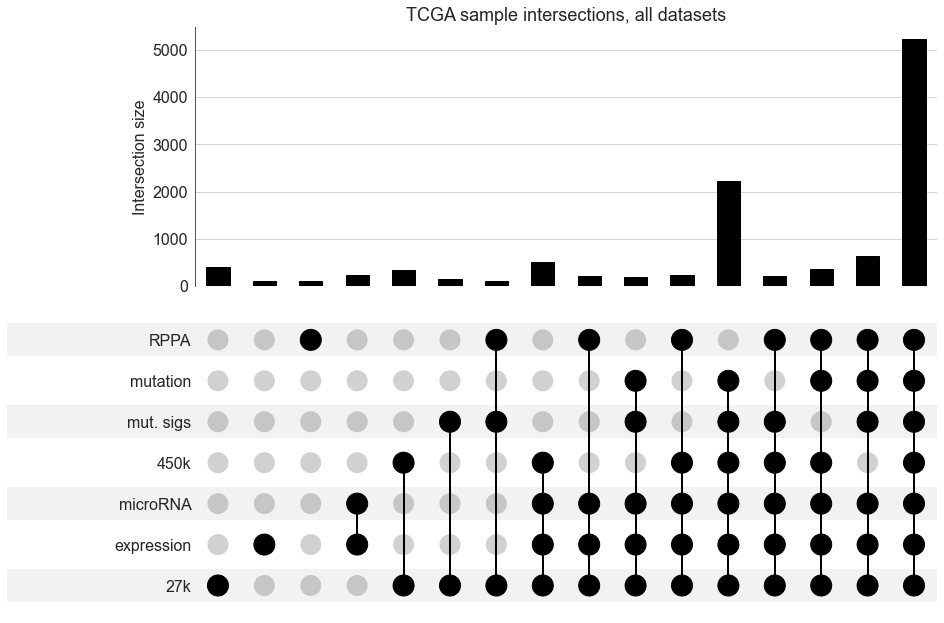

In [12]:
subplots = up.plot(upset_series[upset_series >= 100], element_size=60)
plt.title('TCGA sample intersections, all datasets', size=18)
plt.ylabel('Intersection size', size=16)
plt.yticks(fontsize=16)
subplots['matrix'].set_yticklabels(labels=subplots['matrix'].get_yticklabels(), fontsize=16)
plt.gcf().delaxes(subplots['totals'])

if SAVE_FIGS:
    images_dir = Path(cfg.images_dirs['data'])
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'all_overlap_upset.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'all_overlap_upset.png',
                dpi=300, bbox_inches='tight')

### Cancer type analysis

The sample counts by themselves aren't that informative. More specifically, we want to know which cancer types are getting dropped when we take the overlap between data types. That is, are there certain cancer types that are or are not generally in the overlap, or are the samples we filter out roughly uniformly distributed between cancer types?

In [13]:
# get sample info (sample IDs and cancer types) for each data modality

# there are no samples for which we have mutation data and not other data types,
# so we only need these four

sample_info_dfs = {}
for data_type in cfg.sample_infos.keys():
    sample_info_dfs[data_type] = pd.read_csv(cfg.sample_infos[data_type], 
                                             sep='\t', index_col=0)
print(
    sample_info_dfs['expression'].shape,
    sample_info_dfs['me_27k'].shape,
    sample_info_dfs['me_450k'].shape,
    sample_info_dfs['mut_sigs'].shape,
    sample_info_dfs['rppa'].shape
)
sample_info_dfs['expression'].head()

(11060, 3) (11975, 3) (9629, 3) (9493, 3) (7790, 3)


,sample_type,cancer_type,id_for_stratification
sample_id,,,
TCGA-02-0047-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor
TCGA-02-0055-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor
TCGA-02-2483-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor
TCGA-02-2485-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor
TCGA-02-2486-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor


In [14]:
# the goal here is to examine how the proportion of cancer types changes when we add
# new data modalities

# here, we specify these manually since the order matters
# (i.e. order in data_types => order in which new data is "added")
data_types = ['expression', 'me_27k', 'me_450k', 'mut_sigs', 'mirna', 'rppa']

exp_cancer_types = (sample_info_dfs['expression']
    .groupby('cancer_type')
    .size()
    .sort_values(ascending=False)
)

mutation_samples = sample_lists['mutation']
exp_mut_cancer_types = (sample_info_dfs['expression']
    .loc[mutation_samples]
    .groupby('cancer_type')
    .size()
    .sort_values(ascending=False)
)
diff_df = exp_cancer_types - exp_mut_cancer_types

In [15]:
# check these are all in expression data (they should be)
cur_samples = set(mutation_samples)
diff_df = pd.DataFrame(diff_df, columns=['mutation'])
cur_counts = exp_mut_cancer_types

for ix, data_type in enumerate(data_types[1:], 1):
    cur_samples = cur_samples.intersection(
        sample_lists[data_map[data_type]]
    )
    print(data_type, len(cur_samples))
    overlap_counts = (sample_info_dfs[data_type]
        .loc[cur_samples]
        .groupby('cancer_type')
        .size()
        .reindex(cur_counts.index)
        .fillna(0)
        .sort_values(ascending=False)
    )
    diff = (cur_counts - overlap_counts).astype(int)
    cur_counts = overlap_counts
    df = pd.DataFrame(diff, columns=[data_type])
    diff_df = pd.concat((diff_df, df), axis=1)
    
diff_df = pd.concat((diff_df, 
                     pd.DataFrame(
                         overlap_counts,
                         columns=['rppa_base']
                    )), axis=1).fillna(0).astype(int)
print(diff_df.shape)
diff_df.head(33)

me_27k 9053
me_450k 7981
mut_sigs 7527
mirna 7441
rppa 5226
(33, 7)


,mutation,me_27k,me_450k,mut_sigs,mirna,rppa,rppa_base
cancer_type,,,,,,,
ACC,3,0,0,0,0,32,44
BLCA,29,0,0,20,3,65,310
BRCA,237,16,291,44,9,109,512
CESC,38,0,0,18,0,120,134
CHOL,9,0,3,0,0,6,27
COAD,154,0,77,15,0,33,216
DLBC,11,0,0,6,0,10,21
ESCA,27,0,0,0,0,53,116
GBM,48,0,73,12,39,0,0


In [16]:
# make sure number of removed samples equals number of samples we started with
compare_df = pd.concat((
    pd.DataFrame(
        sample_info_dfs['expression'].groupby('cancer_type').size().fillna(0),
        columns=['expression']
    ), 
    pd.DataFrame(
        diff_df.sum(axis=1),
        columns=['other']
    )
), axis=1)
assert (compare_df.expression.values == compare_df.other.values).all()

Text(0, 0.5, 'Sample count')

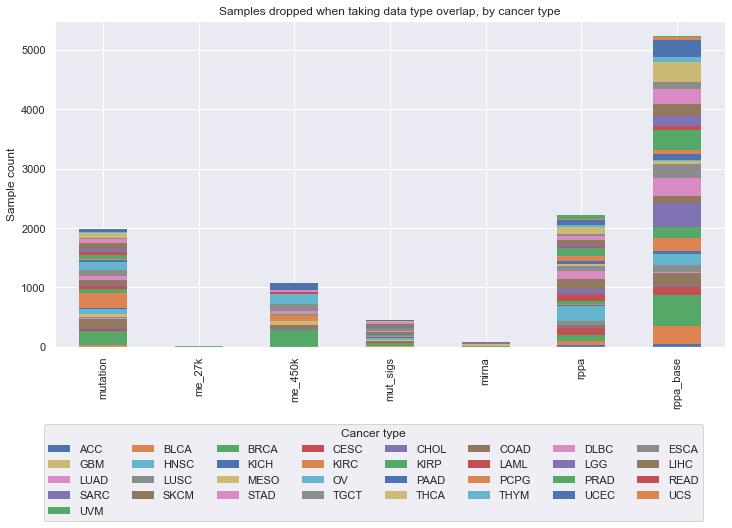

In [17]:
def flip(items, ncol):
    # fill in legend by rows instead of columns
    # https://stackoverflow.com/a/10101532
    import itertools as it
    return it.chain(*[items[i::ncol] for i in range(ncol)])

sns.set()
diff_df.T.plot.bar(stacked=True, figsize=(12, 6), linewidth=0)
h, l = plt.gca().get_legend_handles_labels()
plt.legend(flip(h, 8), flip(l, 8), bbox_to_anchor=(-0.025, -0.55),
           loc='lower left', ncol=8, title='Cancer type')
plt.title('Samples dropped when taking data type overlap, by cancer type')
plt.ylabel('Sample count')

In [18]:
# instead of plotting absolute number of each cancer type dropped at
# each step, plot the proportion of each cancer type (i.e. count divided
# by total sample count for that cancer type)
diff_norm_df = diff_df / np.tile(diff_df.sum(axis=1).values, (diff_df.shape[1], 1)).T
diff_norm_df.head()

,mutation,me_27k,me_450k,mut_sigs,mirna,rppa,rppa_base
cancer_type,,,,,,,
ACC,0.037975,0.000000,0.000000,0.000000,0.000000,0.405063,0.556962
BLCA,0.067916,0.000000,0.000000,0.046838,0.007026,0.152225,0.725995
BRCA,0.194581,0.013136,0.238916,0.036125,0.007389,0.089491,0.420361
CESC,0.122581,0.000000,0.000000,0.058065,0.000000,0.387097,0.432258
CHOL,0.200000,0.000000,0.066667,0.000000,0.000000,0.133333,0.600000


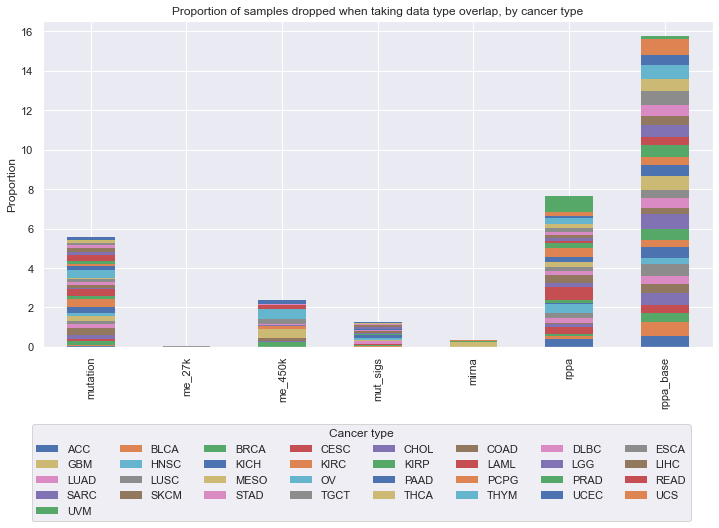

In [19]:
sns.set()
diff_norm_df.T.plot.bar(stacked=True, figsize=(12, 6), linewidth=0)
h, l = plt.gca().get_legend_handles_labels()
plt.legend(flip(h, 8), flip(l, 8), bbox_to_anchor=(-0.025, -0.55),
           loc='lower left', ncol=8, title='Cancer type')
plt.title('Proportion of samples dropped when taking data type overlap, by cancer type')
plt.ylabel('Proportion')

if SAVE_FIGS:
    images_dir = Path(cfg.images_dirs['data'])
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'cancer_type_proportions.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'cancer_type_proportions.png',
                dpi=300, bbox_inches='tight')